In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# FUNCTION

In [2]:
IMAGE_SIZE = 256
NUM_CLASSES = 6

In [3]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
        image = tf.cast(image, dtype=tf.float32)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255
        image = tf.cast(image, dtype=tf.float32)
    return image

def load_data(image_list, mask_list):
    img = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return img, mask

def data_generator(image_list, mask_list, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, UpSampling2D, AveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [5]:
""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    return y

def DeepLabV3Plus(shape, num_class):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(num_class, (1, 1), name='output_layer')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

# GET TRAIN DATA

In [6]:
train_images_0 = []
for i in os.listdir('leftImg8bit\\train'):
    folder_path = 'leftImg8bit\\train\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train\\' + i + '\\' + j
        train_images_0.append(img_path)

train_images_0 = sorted(train_images_0)
print(len(train_images_0))

2975


In [7]:
train_images_light_1 = []
for i in os.listdir('leftImg8bit\\train_light_1'):
    folder_path = 'leftImg8bit\\train_light_1\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_light_1\\' + i + '\\' + j
        train_images_light_1.append(img_path)

train_images_light_1 = sorted(train_images_light_1)
print(len(train_images_light_1))

2975


In [8]:
train_images_light_2 = []
for i in os.listdir('leftImg8bit\\train_light_2'):
    folder_path = 'leftImg8bit\\train_light_2\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_light_2\\' + i + '\\' + j
        train_images_light_2.append(img_path)

train_images_light_2 = sorted(train_images_light_2)
print(len(train_images_light_2))

2975


In [9]:
train_images_night_1 = []
for i in os.listdir('leftImg8bit\\train_night_1'):
    folder_path = 'leftImg8bit\\train_night_1\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_night_1\\' + i + '\\' + j
        train_images_night_1.append(img_path)

train_images_night_1 = sorted(train_images_night_1)
print(len(train_images_night_1))

2975


In [10]:
train_images_night_2 = []
for i in os.listdir('leftImg8bit\\train_night_2'):
    folder_path = 'leftImg8bit\\train_night_2\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_night_2\\' + i + '\\' + j
        train_images_night_2.append(img_path)

train_images_night_2 = sorted(train_images_night_2)
print(len(train_images_night_2))

2975


In [11]:
train_masks_0 = []
train_mask_light_1 = []
train_mask_light_2 = []
train_mask_night_1 = []
train_mask_night_2 = []
for i in os.listdir('mask\\train'):
    train_masks_0.append('mask\\train\\' + i)
    train_mask_light_1.append('mask\\train\\' + i)
    train_mask_light_2.append('mask\\train\\' + i)
    train_mask_night_1.append('mask\\train\\' + i)
    train_mask_night_2.append('mask\\train\\' + i)

train_masks_0 = sorted(train_masks_0)
train_mask_light_1 = sorted(train_mask_light_1)
train_mask_light_2 = sorted(train_mask_light_2)
train_mask_night_1 = sorted(train_mask_night_1)
train_mask_night_2 = sorted(train_mask_night_2)
print(len(train_masks_0))
print(len(train_mask_light_1))
print(len(train_mask_light_2))
print(len(train_mask_night_1))
print(len(train_mask_night_2))

2975
2975
2975
2975
2975


In [12]:
train_images = train_images_0 + train_images_light_1 + train_images_light_2 + train_images_night_1 + train_images_night_2
train_masks = train_masks_0 + train_mask_light_1 + train_mask_light_2 + train_mask_night_1 + train_mask_night_2

# GET VALID DATA

In [13]:
val_images = []
for i in os.listdir('leftImg8bit\\val'):
    folder_path = 'leftImg8bit\\val\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\val\\' + i + '\\' + j
        val_images.append(img_path)

val_images = sorted(val_images)
print(len(val_images))

500


In [14]:
val_masks = []
for i in os.listdir('mask\\val'):
    val_masks.append('mask\\val\\' + i)

val_masks = sorted(val_masks)
print(len(val_masks))

500


# GENERATOR

In [15]:
train_dataset = data_generator(train_images, train_masks, 4)
val_dataset = data_generator(val_images, val_masks, 2)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 256, 256, 1), dtype=tf.float32, name=None))>


In [16]:
input_shape = (256, 256, 3)
model = DeepLabV3Plus(input_shape, num_class=6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
print(len(train_images))
print(len(val_images))

14875
500


In [18]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=loss)

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)

Epoch 1/20
3718/3718 [==============================] - 1478s 390ms/step - loss: 0.2137 - val_loss: 0.3063
Epoch 2/20
3718/3718 [==============================] - 1448s 389ms/step - loss: 0.1285 - val_loss: 0.3009
Epoch 3/20
3718/3718 [==============================] - 1450s 390ms/step - loss: 0.0970 - val_loss: 0.2543
Epoch 4/20
3718/3718 [==============================] - 1448s 389ms/step - loss: 0.0788 - val_loss: 0.2719
Epoch 5/20
3718/3718 [==============================] - 1448s 389ms/step - loss: 0.0675 - val_loss: 0.6131
Epoch 6/20
3718/3718 [==============================] - 1449s 390ms/step - loss: 0.0599 - val_loss: 0.3965
Epoch 7/20
3718/3718 [==============================] - 1451s 390ms/step - loss: 0.0558 - val_loss: 0.2430
Epoch 8/20
3718/3718 [==============================] - 1450s 390ms/step - loss: 0.0486 - val_loss: 0.5291
Epoch 9/20
3718/3718 [==============================] - 1454s 391ms/step - loss: 0.0456 - val_loss: 0.3177
Epoch 10/20
3718/3718 [==============

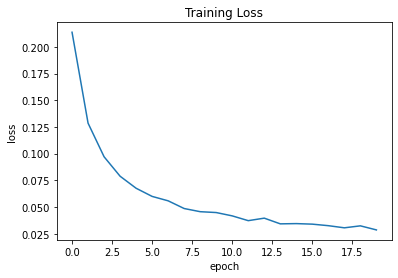

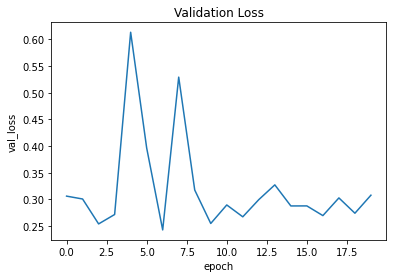

In [19]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

In [21]:
model.save('D:\\CV\\modelDLv3.h5')